In [1]:
%matplotlib notebook
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array, linspace
from IPython.display import display_latex, Latex, display

from sympy import Symbol, init_printing, integrate, sqrt, atan, latex
from scipy.optimize import minimize_scalar
init_printing()

$$\newcommand{\eps}{\varepsilon}$$

# План 

1. Численное интегрироване:
    - Постановка задачи;
    - Формулы Ньютона-Котеса;
    - Формулы Гаусса (наивысшей степени точности для единичного веса);
    - Правила апостериорной оценки погрешности и уточнения результата;
    - [Формулы Гаусса-Кристофеля, Чебышева, Филона];
2. Численное дифференцирование:
    - Постановка задачи;
    - [Дифференцирование с помощью полиномов Лагранжа и Ньютона];
    - Дифференцирование с помощью рядов Тейлора.

## Численное интегрирование

### Интерполяционное интегрирование

Численное интегрирование имеет довольно интуитивную аналогию с интегральными суммами Римана со специальным образом выбранными особыми точками.

Согласно с формулой Ньютона-Котеса первого порядка, интеграл приближенно равен 
$$\int_a^b{f(x)dx} \approx (b-a) f\left(\frac{a+b}{2}\right).$$

Пользоваться ей в таком виде не очень хорошо: куда более высокие результаты показывает применение этой формулы на частичных отрезках, на которые разбивается исходный промежуток. Если шаг фиксирован и равен $h$, формула примет такой вид:
$$\int_a^b{f(x)dx} \approx h \sum_{i=1}^n f\left( \frac{x_{i-1} + x_i}{2} \right) $$
Похоже ведь на интегральную сумму Римана, в которой положили частичные отрезки  равными, а в качестве особых точек взяли середины этих отрезков. Погрешность такого вычисления имеет порядок $O(h^2)$. Более точно, оценка погрешности имеет вид
$$\rvert R_1^N[f]\rvert \leq \frac{b-a}{24}h^2 M_2.$$ 

In [2]:
def integrate_nc(func, a, b, n, method, return_evalueted_func=False):
    
    x = linspace(a, b, n+1)
    h = (b - a) / n
    
    if method == 'left_rect':
        f = array(list(map(func, x[:-1])))
    elif method == 'right_rect':
        f = array(list(map(func, x[1:])))
    elif method == 'mid_rect':
        f = array(list(map(func, 0.5*x[:-1] + 0.5*x[1:])))
    elif method == 'trapeze':
        f = array(list(map(func, x)))
        f = 0.5 * (f[:-1] + f[1:])
    elif method == 'simpson' or method == 'parabola':
        if n % 2 != 0:
            raise ValueError("Simpson's method only works for even number of nodes!")
        f = array(list(map(func, x))) / 3
        f[1:-1:2] *= 4
        f[2:-2:2] *= 2
    
    if return_evalueted_func:
        return h*f.sum(), f
    
    return h*f.sum()

Оценка погрешности по правилу Рунге (здесь $n_1 = \frac{n_2}{2}$, а $p$ - алгебраическая точность метода):
$$\Delta I_{n_1}=\frac{I_{n_2}-I_{n_1}}{1-2^{-p}}, \Delta I_{n_2}=\frac{I_{n_2}-I_{n_1}}{2^p-1}.$$

Уточнение интеграла методом экстраполяции Ричардсона (можем повысить степень метода на единицу):
$$ I_{n_1, n_2} = I_{n_2} + \frac{n_1^p}{n_2^p-n_1^p}(I_{n_2}-I_{n_1}) .$$

### Задача 1

Сперва нам нужно посчитать значение интеграла $\int\limits_{-2}^2 \frac{dx}{3x^2+4x+2}$ разными методами и для разного количества частей, на которые разбивается исходный отрезок ($n_1=4, n_2=8$). 
Затем нужно оценить погрешность с помощью метода Рунге и также необходимо уточнить интеграл $I_{n_2}$ с помощью экстраполяции Ричардсона.

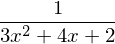

In [3]:
x = Symbol('x')
f = 1 / (3*x**2 + 4*x + 2)
f

In [4]:
I = integrate(f, (x, -2, 2)).evalf()
print('Precise value of integral: %.5f' % I)
print('Approximation results:')
for method, p in zip(['left_rect', 'mid_rect', 'right_rect', 'trapeze', 'simpson'], [1, 2, 1, 2, 4]):
    print('- Method = %s, p = %d' % (method, p), end='')
    
    I4 = integrate_nc(lambda x0: f.subs(x, x0), -2, 2, 4, method)
    I8 = integrate_nc(lambda x0: f.subs(x, x0), -2, 2, 8, method)
    display(Latex("$I_4 = %.4f, I_8 = %.4f$" % (I4, I8)))
    
    delta_I4 = (I8 - I4) / (1 - 2**(-p))
    delta_I8 = delta_I4 / 2**p   
    display(Latex("$\Delta I_4 = %.4f, \\lvert I_4 - I \\rvert = %.4f.$" % (delta_I4, np.abs(I4 - I) ) ))
    display(Latex("$\Delta I_8 = %.4f, \\lvert I_8 - I \\rvert = %.4f.$" % (delta_I8, np.abs(I8 - I) ) ))
    
    I_rich = I8 + 4**p / (8**p - 4**p) * (I8 - I4)
    display(Latex("$I_{4, 8} = %.4f, \\lvert I_{4, 8} - I \\rvert = %.4f.$" % (I_rich, np.abs(I_rich-I))))

Precise value of integral: 1.85742
Approximation results:
- Method = left_rect, p = 1

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

- Method = mid_rect, p = 2

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

- Method = right_rect, p = 1

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

- Method = trapeze, p = 2

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

- Method = simpson, p = 4

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Задача 2

Теперь посчитаем численное значение интеграла $\int\limits_{1,4}^{2,1} \frac{dx}{\sqrt{3x^2-1}}$ так, чтобы абсолютная погрешность не превышала $\eps = 0,5 \cdot 10^{-3}$.

In [5]:
f = 1 / sqrt(3*x**2 - 1)
display(Latex("$f(x)="+latex(f)+"$"))
f_sec_deriv = f.diff(x, 2).simplify()
display(Latex("$f''(x)="+latex(f_sec_deriv)+"$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Учитывая, что наша функция дважды непрерывно дифференцируема в области определения, для нахождения длины шага можем воспользоваться оценкой остаточного члена, которая указана выше. Итак, $h$ найдём из неравенства 
$h \leq \sqrt{ \frac{24\eps}{(b-a)M_2} }$, где $M_2$ - максимум модуля второй производной в области определения. 

In [6]:
res = minimize_scalar(lambda v: -f_sec_deriv.subs(x, v), bounds=(1.4, 2.1), method='Bounded')
display(Latex("$M_2 = %.3f.$" % (-res.fun)))

h = np.sqrt(24 * 0.5e-3 / 0.7 / 0.728)
print("Desired step value: %.3f, requiered number of steps: %d.\n" % (h, int(np.ceil(0.7 / h))))

<IPython.core.display.Latex object>

Desired step value: 0.153, requiered number of steps: 5.



В нашем случае получаем, что шаг должен быть не больше, чем $0.153$, поэтому посчитаем интеграл, разбив отрезок на $5$ частей.
В итоге получили действительно довольно близкое к точному значение интеграла.

In [7]:
int_approx = integrate_nc(lambda v: f.subs(x, v), 1.4, 2.1, 6, method='mid_rect')
int_precise = integrate(f, (x, 1.4, 2.1)).evalf()

print("Approximate value of integral: %.5f." % int_approx)
print("Integration error: %.5f < 0,5\u00B710\u207B\u00B3" % np.abs(int_approx - int_precise))

Approximate value of integral: 0.24901.
Integration error: 0.00014 < 0,5·10⁻³


### Формулы наивысшей степени алгебраической точности (в т.ч., формула Гаусса)



In [8]:
def integrate_gauss(func, a, b, n):
    from numpy.polynomial import Legendre
    
    t = Legendre([0]*n+[1]).roots()
    x = Legendre([0]*n+[1], domain=[a, b]).roots()
    f = array(list(map(lambda x0: func(x0), x)))
    P = Legendre([0]*(n-1)+[1])
    A = np.zeros(n)
    
    for k in range(n):
        A[k] = 2 * (1 - t[k]**2) / (n**2 * P(t[k])**2)
    
    return (b - a) * np.dot(A, f) / 2

### Задача 3 

По формуле Гаусса необходимо вычислить интеграл $\int\limits_{-0,5}^{1,3} \frac{x^2 dx}{\sqrt{x^2+1}}$ используя для оценки точности двойной пересчёт при  $n_1=4$ и $n_2=5$.

In [9]:
f = x**2 / sqrt(x**2 + 1)
[a, b] = [-0.5, 1.3]
[n1, n2] = [4, 5]

In1 = integrate_gauss(lambda x0: f.subs(x, x0), a, b, n1)
In2 = integrate_gauss(lambda x0: f.subs(x, x0), a, b, n2)
print("Approximation with Gauss formula for n=4: %.6f." % In1)
print("Approximation with Gauss formula for n=5: %.6f." % In2)

I = integrate(f, (x, a, b))
print("Precise value of integral: %.6f." % I)

Approximation with Gauss formula for n=4: 0.565516.
Approximation with Gauss formula for n=5: 0.565793.
Precise value of integral: 0.565756.


Будем считать верными те цифры, которые совпали для обоих способов. Итак, заключаем, что $\hat{I}=0,565$. Как видим, значение достаточно близко к истинному.

## Численное дифференцирование


Такие формулы можно получить с помощью разложения функции $f(x)$ по формуле Тейлора до 2-го или до 3-го порядка.
Левая производная (в лекциях $y_{\overline{x},i}$): $$f_i' ^{-} \approx\frac{f_{i+1}-f_i}{h}.$$
Правая производная (в лекциях $y_{x, i})$: $$f_i' ^{+}\approx\frac{f_i - f_{i-1}}{h}.$$
Эти производные имеют порядок погрешности $O(h)$.

Центральная производная (в лекциях  $y_{\overset{\circ}{x}, i}$) уже имеет порядок погрешности $O(h^2)$:  $$f_i' ^{\circ}\approx\frac{f_{i+1} - f_{i-1}}{2h}.$$

Формула для второй производной (в лекциях $y_{\overline{x}x, i}$): $$f_i'' ^{\circ}\approx\frac{f_{i+1}-2f_i + f_{i-1}}{h^2}$$

In [10]:
def ndiff(func, a, b, h, how='mid'):
    
    x = linspace(a, b, int((b-a)/h + 1))
    f = array(list(map(func, x)))
    
    if how == 'left':
        return np.r_[f[1:] - f[:-1], np.nan] / h
    elif how == 'right':
        return np.r_[np.nan, f[1:] - f[:-1]] / h
    elif how == 'mid':
        return np.r_[np.nan, f[2:] - f[:-2], np.nan] / 2 / h
    else:
        raise ValueError('Incorrect value for "how" parameter.')

def ndiff2(func, a, b, h):
    
    x = linspace(a, b, int((b-a)/h + 1))
    f = array(list(map(func, x)))
    return np.r_[np.nan, f[2:] - 2*f[1:-1] + f[:-2], np.nan] / h**2

def ndiff_results(func, a, b, h):
    from pandas import DataFrame, Series
    
    res = DataFrame(columns=['$x_i$', '$f_i$',
                             "$f_i' ^{-}$", "$f_i' ^{+}$", 
                             "$f_i' ^{\circ}$", "$f_i'' ^{\circ}$"])
    
    x = linspace(a, b, int((b-a)/h + 1))
    res.iloc[:, 0] = x
    res.iloc[:, 1] = array(list(map(func, x)))
    res.iloc[:, 2] = ndiff(func, a, b, h, 'left')
    res.iloc[:, 3] = ndiff(func, a, b, h, 'right')
    res.iloc[:, 4] = ndiff(func, a, b, h, 'mid')
    res.iloc[:, 5] = ndiff2(func, a, b, h)
    return res

### Задача 4

Составить таблицу производных $f_i' ^{-}$, $f_i' ^{+}$, $f_i' ^{\circ}$, $f_i'' ^{\circ}$ для функци $f(x) = \arctan{\frac{1}{x^2}} - x$ на отрезке $x\in [-1,5; -0,5]$, положив шаг равным $0,1$.

In [11]:
f = atan(1 / x**2) - x
display(Latex("$f(x) = {}.$".format(latex(f))))
res = ndiff_results(lambda x0: f.subs(x, x0), -1.5, -0.5, 0.1)
res

<IPython.core.display.Latex object>

,$x_i$,$f_i$,$f_i' ^{-}$,$f_i' ^{+}$,$f_i' ^{\circ}$,$f_i'' ^{\circ}$
0,-1.5,1.91822432957923,-0.464468183984792,NaN,NaN,NaN
1,-1.4,1.87177751118075,-0.374714718646096,-0.464468183984792,-0.419591451315444,0.897534653386955
2,-1.3,1.83430603931614,-0.273183752697324,-0.374714718646096,-0.323949235671710,1.01530965948773
3,-1.2,1.80698766404641,-0.163276686648315,-0.273183752697324,-0.218230219672819,1.09907066049009
4,-1.1,1.79065999538158,-0.0526183198412822,-0.163276686648315,-0.107947503244799,1.10658366807033
5,-1.0,1.78539816339745,0.0458933448162080,-0.0526183198412822,-0.00336248751253709,0.985116646574901
6,-0.9,1.78998749787907,0.114956378151656,0.0458933448162080,0.0804248614839320,0.690630333354480
7,-0.8,1.80148313569423,0.136975378894375,0.114956378151656,0.125965878523016,0.220190007427190
8,-0.7,1.81518067358367,0.100600726295124,0.136975378894375,0.118788052594749,-0.363746525992514
9,-0.6,1.82524074621318,0.00576917454848003,0.100600726295124,0.0531849504218018,-0.948315517466436


<IPython.core.display.Javascript object>


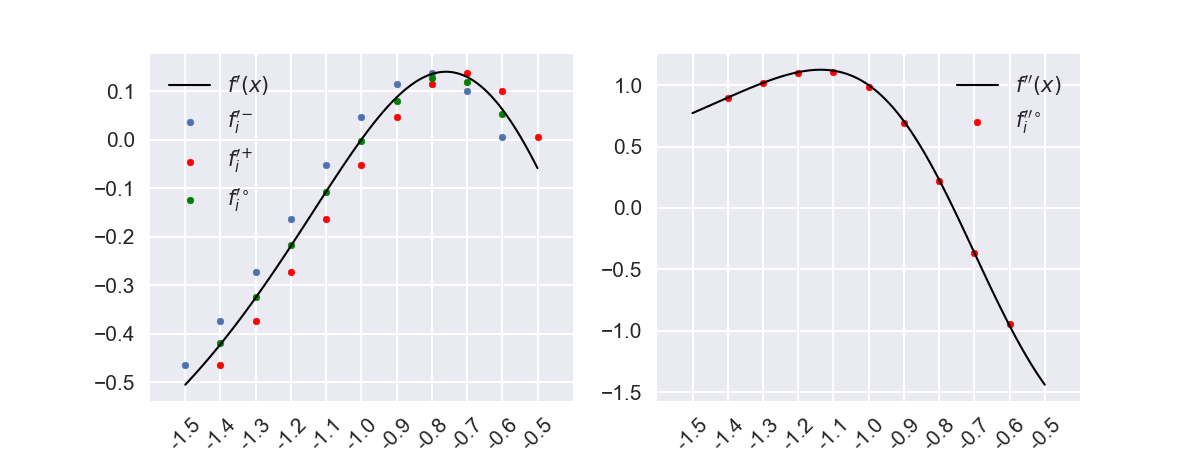

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 3))
x_grid = linspace(-1.5, -0.5, 101)
axes[0].set_xlim(-1.6, -0.4);
for ax in axes:
    ax.set_xticklabels(res.iloc[:, 0], rotation=45)
    ax.set_xticks(res.iloc[:, 0])
    
axes[0].scatter(res.iloc[:, 0], res.iloc[:, 2], label="$f_i' ^{-}$", s=10)
axes[0].scatter(res.iloc[:, 0], res.iloc[:, 3], label="$f_i' ^{+}$", s=10, c='r')
axes[0].scatter(res.iloc[:, 0], res.iloc[:, 4], label="$f_i' ^{\circ}$", s=10, c='g')
axes[0].plot(x_grid, list(map(lambda v: f.diff(x).subs(x, v), x_grid)), linewidth=1, c='black', label="$f'(x)$")
axes[0].legend()

axes[1].scatter(res.iloc[:, 0], res.iloc[:, -1], label="$f_i'' ^{\circ}$", s=10, c='r')
axes[1].plot(x_grid, list(map(lambda v: f.diff(x, 2).subs(x, v), x_grid)), linewidth=1, c='black', label="$f''(x)$")
axes[1].legend();